# Case Técnico – Cientista de Dados Júnior | Datarisk 2025

Este notebook apresenta a solução desenvolvida para o desafio proposto pela Datarisk com o objetivo de prever a **probabilidade de inadimplência** de cobranças financeiras com base em dados históricos de clientes.

A estrutura deste projeto segue as etapas de um pipeline moderno de ciência de dados, organizado nas seguintes camadas:

- **Raw**: Carga inicial dos dados brutos.
- **Trusted**: Padronização e tratamento de dados.
- **Refined**: Engenharia de variáveis e criação da variável-alvo.
- **Modelagem**: Treinamento do modelo de Machine Learning.
- **Predição**: Geração de previsões no conjunto de teste.
- **Análise Executiva**: Interpretação dos resultados gerados.


## Objetivo

O objetivo deste case é construir um modelo preditivo que estime a **probabilidade de inadimplência** em cobranças mensais. A definição de inadimplência, conforme regra de negócio, é:

> Um pagamento é considerado inadimplente se for realizado com **5 dias ou mais de atraso** em relação à data de vencimento.

As previsões devem ser feitas sobre os registros da base `base_pagamentos_teste.csv`, contendo apenas as seguintes colunas no arquivo final `submissao_case.csv`:

- `ID_CLIENTE`
- `SAFRA_REF`
- `PROBABILIDADE_INADIMPLENCIA`


## Camada Raw – Carregamento dos dados brutos

Nesta etapa, realizamos a importação direta dos arquivos CSV fornecidos, representando os dados ainda sem transformações. Todas as bases são lidas e identificamos seu tamanho e estrutura inicial.
- Importação de bibliotecas e leitura bruta dos dados

In [1]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações visuais
pd.set_option('display.max_columns', 100)
sns.set_theme(style="whitegrid")

# Carregamento dos arquivos (considerando separador ';')
df_cadastral = pd.read_csv('base_cadastral.csv', sep=';')
df_info = pd.read_csv('base_info.csv', sep=';')
df_pagamentos_dev = pd.read_csv('base_pagamentos_desenvolvimento.csv', sep=';')
df_pagamentos_teste = pd.read_csv('base_pagamentos_teste.csv', sep=';')


- Visualização das dimensões iniciais

In [2]:
# Tamanho de cada dataset
print("Dimensões dos datasets:")
print(f"- Base Cadastral: {df_cadastral.shape}")
print(f"- Base Info Mensal: {df_info.shape}")
print(f"- Base Pagamentos Desenvolvimento: {df_pagamentos_dev.shape}")
print(f"- Base Pagamentos Teste: {df_pagamentos_teste.shape}")

Dimensões dos datasets:
- Base Cadastral: (1315, 8)
- Base Info Mensal: (24401, 4)
- Base Pagamentos Desenvolvimento: (77414, 7)
- Base Pagamentos Teste: (12275, 6)


- Visualização das primeiras linhas

In [3]:
# Primeiras linhas das bases
display(df_cadastral.head())
display(df_info.head())
display(df_pagamentos_dev.head())
display(df_pagamentos_teste.head())


,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,NaN,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,NaN,Serviços,GMAIL,GRANDE,62


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,NaN
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99


>  Concluímos a importação e a inspeção básica das 4 bases fornecidas. A partir de agora, seguiremos para a **Camada Trusted**, onde trataremos tipos de dados, datas e valores ausentes para padronizar os conjuntos e permitir análises consistentes.

## Camada Trusted – Tratamento e Padronização

Nesta etapa, realizamos os primeiros tratamentos para padronizar os dados:
- Conversão de colunas de datas para o tipo `datetime`
- Análise e tratamento de valores ausentes
- Padronização de colunas categóricas
- Verificação de integridade das chaves (`ID_CLIENTE`, `SAFRA_REF`) que serão usadas na fusão das bases


In [4]:
# Conversão de colunas de data
date_cols_pag_dev = ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO', 'DATA_PAGAMENTO']
date_cols_pag_teste = ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO']

for col in date_cols_pag_dev:
    df_pagamentos_dev[col] = pd.to_datetime(df_pagamentos_dev[col])

for col in date_cols_pag_teste:
    df_pagamentos_teste[col] = pd.to_datetime(df_pagamentos_teste[col])

# Convertendo também SAFRA_REF (mensal) em formato YYYY-MM
df_info['SAFRA_REF'] = pd.to_datetime(df_info['SAFRA_REF'], format='%Y-%m')
df_pagamentos_dev['SAFRA_REF'] = pd.to_datetime(df_pagamentos_dev['SAFRA_REF'], format='%Y-%m')
df_pagamentos_teste['SAFRA_REF'] = pd.to_datetime(df_pagamentos_teste['SAFRA_REF'], format='%Y-%m')
df_cadastral['DATA_CADASTRO'] = pd.to_datetime(df_cadastral['DATA_CADASTRO'])

- Verificação de valores ausentes

In [5]:
# Função para checar valores ausentes
def check_missing(df, name):
    nulls = df.isnull().sum()
    percent = (nulls / len(df)) * 100
    return pd.DataFrame({'coluna': nulls.index, 'faltantes': nulls.values, 'percentual': percent.values}).query('faltantes > 0').sort_values(by='percentual', ascending=False).assign(base=name)

# Checar ausentes nas 4 bases
missing_cadastral = check_missing(df_cadastral, 'cadastral')
missing_info = check_missing(df_info, 'info')
missing_dev = check_missing(df_pagamentos_dev, 'pag_dev')
missing_teste = check_missing(df_pagamentos_teste, 'pag_teste')

# Concatenar para visualização
pd.concat([missing_cadastral, missing_info, missing_dev, missing_teste])

,coluna,faltantes,percentual,base
3,FLAG_PF,1249,94.980989,cadastral
2,DDD,237,18.022814,cadastral
4,SEGMENTO_INDUSTRIAL,83,6.311787,cadastral
6,PORTE,41,3.117871,cadastral
5,DOMINIO_EMAIL,30,2.281369,cadastral
3,NO_FUNCIONARIOS,1252,5.130937,info
2,RENDA_MES_ANTERIOR,717,2.938404,info
5,VALOR_A_PAGAR,1170,1.511355,pag_dev
4,VALOR_A_PAGAR,131,1.067210,pag_teste


### Análise de valores ausentes

- A base `df_info` apresenta valores ausentes nas colunas `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS`
- A base `df_cadastral` possui campos faltantes em `FLAG_PF`, indicando ausência de tipo de cliente
- Essas informações são importantes e devem ser analisadas com cautela: podemos imputar, transformar em categorias ou criar flags binárias


- Correções e preenchimentos simples

In [6]:
# Preencher FLAG_PF com "PJ" quando nulo, já que ausência sugere Pessoa Jurídica
df_cadastral['FLAG_PF'] = df_cadastral['FLAG_PF'].fillna('PJ')

# Converter FLAG_PF para binário (1 = PF, 0 = PJ)
df_cadastral['FLAG_PF'] = (df_cadastral['FLAG_PF'] == 'X').astype(int)

# Preencher RENDA e FUNCIONÁRIOS com mediana do cliente (ou zero)
df_info['RENDA_MES_ANTERIOR'] = df_info['RENDA_MES_ANTERIOR'].fillna(0)
df_info['NO_FUNCIONARIOS'] = df_info['NO_FUNCIONARIOS'].fillna(0)

### Preparação para Fusão
### Padronização de chaves para fusão

Para facilitar a integração entre as bases, confirmamos que os campos `ID_CLIENTE` e `SAFRA_REF` estão presentes e padronizados. A seguir, vamos unir as tabelas para formar uma base consolidada para exploração e modelagem.


## Camada Refined – Feature Engineering e Criação da Variável-Alvo

Esta etapa envolve a transformação dos dados para que eles estejam prontos para alimentar um modelo de aprendizado de máquina. Executamos as seguintes ações:

- Construção da variável-alvo `INADIMPLENTE`, conforme a regra:  
  > Pagamentos com **5 ou mais dias de atraso** são considerados inadimplentes.
- Geração de novas variáveis a partir do histórico de pagamento
- Agregações por cliente para capturar comportamentos históricos
- Fusão das bases em um único dataset confiável


In [7]:
# Calcular dias de atraso
df_pagamentos_dev['DIAS_ATRASO'] = (df_pagamentos_dev['DATA_PAGAMENTO'] - df_pagamentos_dev['DATA_VENCIMENTO']).dt.days

# Regra: inadimplente se atraso for >= 5 dias
df_pagamentos_dev['INADIMPLENTE'] = (df_pagamentos_dev['DIAS_ATRASO'] >= 5).astype(int)

# Se DATA_PAGAMENTO estiver ausente, consideramos automaticamente como inadimplente (embora nesse caso não há nulos)
df_pagamentos_dev['INADIMPLENTE'] = df_pagamentos_dev['INADIMPLENTE'].fillna(1)


### Análise da variável-alvo `INADIMPLENTE`

A variável-alvo é binária, onde:
- 1 representa inadimplência (pagamento com atraso ≥ 5 dias)
- 0 representa pagamento em dia

É fundamental entender a distribuição da target para escolher métricas apropriadas e balancear o modelo.


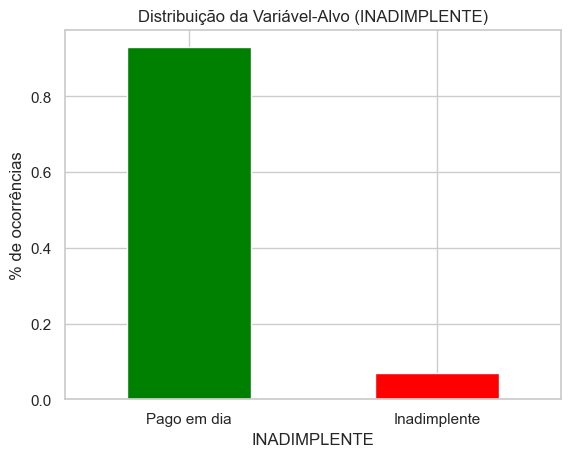

In [8]:
# Distribuição simples
df_pagamentos_dev['INADIMPLENTE'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
plt.title('Distribuição da Variável-Alvo (INADIMPLENTE)')
plt.xticks(ticks=[0, 1], labels=['Pago em dia', 'Inadimplente'], rotation=0)
plt.ylabel('% de ocorrências')
plt.grid(True)
plt.show()

### Geração de variáveis agregadas por cliente

Para cada cliente, podemos criar estatísticas do seu histórico de pagamentos, como:
- Quantidade total de documentos
- Valor médio, mediano e desvio padrão das faturas
- Taxa de inadimplência histórica
- Média de atraso (apenas se inadimplente)

Essas variáveis ajudam a capturar o comportamento do cliente e são bons preditores para inadimplência futura.


In [9]:
# Agregações históricas por cliente
agg_por_cliente = df_pagamentos_dev.groupby("ID_CLIENTE").agg(
    QTD_DOCUMENTOS=("VALOR_A_PAGAR", "count"),
    VALOR_MEDIO_FATURA=("VALOR_A_PAGAR", "mean"),
    VALOR_MEDIANO_FATURA=("VALOR_A_PAGAR", "median"),
    VALOR_STD_FATURA=("VALOR_A_PAGAR", "std"),
    TAXA_MEDIA=("TAXA", "mean"),
    DIAS_ATRASO_MEDIO=("DIAS_ATRASO", "mean"),
    DIAS_ATRASO_MAXIMO=("DIAS_ATRASO", "max"),
    INADIMPLENCIAS=("INADIMPLENTE", "sum"),
    TAXA_INADIMPLENCIA=("INADIMPLENTE", "mean")
).reset_index()

### Unificação das bases para treino

Com todas as bases tratadas e agregadas, unimos:

1. `df_pagamentos_dev` com `df_info` (por `ID_CLIENTE` + `SAFRA_REF`)
2. O resultado com `df_cadastral` (por `ID_CLIENTE`)
3. E por fim com os dados agregados `agg_por_cliente` (por `ID_CLIENTE`)

Assim obtemos um dataset robusto com o rótulo `INADIMPLENTE` e todas as variáveis preditoras.


In [10]:
df_merged_info_cad = pd.merge(df_info, df_cadastral, on='ID_CLIENTE', how='left')

df_train = pd.merge(df_pagamentos_dev, df_merged_info_cad, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')
df_test = pd.merge(df_pagamentos_teste, df_merged_info_cad, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

df_train = pd.merge(df_train, agg_por_cliente, on='ID_CLIENTE', how='left')
df_test = pd.merge(df_test, agg_por_cliente, on='ID_CLIENTE', how='left')

# Visualização final
print("Formato final da base de treino:", df_train.shape)
print(df_train.head())
print(df_test.head())


Formato final da base de treino: (77414, 27)
            ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO  \
0  1661240395903230676 2018-08-01             2018-08-17     2018-09-06   
1  1661240395903230676 2018-08-01             2018-08-19     2018-09-11   
2  1661240395903230676 2018-08-01             2018-08-26     2018-09-18   
3  1661240395903230676 2018-08-01             2018-08-30     2018-10-11   
4  1661240395903230676 2018-08-01             2018-08-31     2018-09-20   

  DATA_VENCIMENTO  VALOR_A_PAGAR  TAXA  DIAS_ATRASO  INADIMPLENTE  \
0      2018-09-06       35516.41  6.99            0             0   
1      2018-09-10       17758.21  6.99            1             0   
2      2018-09-17       17431.96  6.99            1             0   
3      2018-10-05        1341.00  6.99            6             1   
4      2018-09-20       21309.85  6.99            0             0   

   RENDA_MES_ANTERIOR  NO_FUNCIONARIOS DATA_CADASTRO  DDD  FLAG_PF  \
0                 N

In [11]:
# Checando valores ausentes na Base de Treino
missing_train = check_missing(df_train, 'Treino')
pd.concat([missing_train])

,coluna,faltantes,percentual,base
12,DDD,10840,14.002635,Treino
16,PORTE,6302,8.140646,Treino
14,SEGMENTO_INDUSTRIAL,5231,6.757176,Treino
15,DOMINIO_EMAIL,4758,6.146175,Treino
10,NO_FUNCIONARIOS,3937,5.085643,Treino
17,CEP_2_DIG,3937,5.085643,Treino
11,DATA_CADASTRO,3937,5.085643,Treino
9,RENDA_MES_ANTERIOR,3937,5.085643,Treino
13,FLAG_PF,3937,5.085643,Treino
5,VALOR_A_PAGAR,1170,1.511355,Treino


## Tratamento de Valores Ausentes na base de Treino e Exploração dos Dados

Após consolidar a base de treino, identificamos colunas com valores ausentes que precisam ser tratados antes da modelagem.

Além disso, nesta seção realizamos uma **exploração visual** detalhada de variáveis numéricas e categóricas, identificando padrões úteis para o modelo.

A presença de `NaN` pode causar falhas ou vieses durante o treinamento. Por isso, tratamos cada coluna de forma adequada:

- Variáveis categóricas: imputadas com **moda** (`fillna(df[col].mode()[0])`)
- Variáveis numéricas: imputadas com **mediana** (mais robusta a outliers)


In [12]:
# Processamento padronizado
dataframes_to_process = {'train': df_train, 'test': df_test}

for name, df in dataframes_to_process.items():

    # Datas
    date_cols_to_convert = ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO']
    if name == 'train':
        date_cols_to_convert.append('DATA_PAGAMENTO')

    for col in date_cols_to_convert:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if 'DATA_CADASTRO' in df.columns:
        df['DATA_CADASTRO'] = pd.to_datetime(df['DATA_CADASTRO'], errors='coerce')

    # Features Temporais
    df['MES_VENCIMENTO'] = df['DATA_VENCIMENTO'].dt.month
    df['ANO_VENCIMENTO'] = df['DATA_VENCIMENTO'].dt.year
    df['DIA_SEMANA_VENCIMENTO'] = df['DATA_VENCIMENTO'].dt.dayofweek
    df['DIA_DO_MES_VENCIMENTO'] = df['DATA_VENCIMENTO'].dt.day
    df['DIAS_ATE_VENCIMENTO'] = (df['DATA_VENCIMENTO'] - df['DATA_EMISSAO_DOCUMENTO']).dt.days

    # Tempo de Cliente
    if 'SAFRA_REF' in df.columns:
        df['SAFRA_REF'] = pd.to_datetime(df['SAFRA_REF'], errors='coerce')
        if pd.api.types.is_datetime64_any_dtype(df['DATA_CADASTRO']):
            df['TEMPO_DE_CLIENTE_MESES'] = (df['SAFRA_REF'].dt.year - df['DATA_CADASTRO'].dt.year) * 12 + \
                                           (df['SAFRA_REF'].dt.month - df['DATA_CADASTRO'].dt.month)
            df['TEMPO_DE_CLIENTE_MESES'] = df['TEMPO_DE_CLIENTE_MESES'].apply(lambda x: x if x >= 0 else np.nan)
        else:
            df['TEMPO_DE_CLIENTE_MESES'] = np.nan

    # Features de Razão
    df['VALOR_POR_FUNCIONARIO'] = df['VALOR_A_PAGAR'] / (df['NO_FUNCIONARIOS'].replace(0, np.nan).fillna(1) + 1)
    df['TAXA_SOBRE_VALOR'] = df['TAXA'] / df['VALOR_A_PAGAR'].replace(0, np.nan)

    # Tratamento FLAG_PF
    if 'FLAG_PF' in df.columns:
        df['FLAG_PF'] = df['FLAG_PF'].replace({'X': 'PF', np.nan: 'PJ'})

    # Imputações
    num_cols = [
        'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'VALOR_A_PAGAR',
        'TEMPO_DE_CLIENTE_MESES', 'VALOR_POR_FUNCIONARIO', 'TAXA_SOBRE_VALOR',
        'QTD_DOCUMENTOS', 'VALOR_MEDIO_FATURA', 'VALOR_MEDIANO_FATURA',
        'VALOR_STD_FATURA', 'TAXA_MEDIA', 'DIAS_ATRASO_MEDIO',
        'DIAS_ATRASO_MAXIMO', 'INADIMPLENCIAS', 'TAXA_INADIMPLENCIA'
    ]
    for col in num_cols:
        if col in df.columns and df[col].isnull().any():
            mediana = df[col].median()
            df[col] = df[col].fillna(mediana)
            
    cat_cols = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'DDD']
    for col in cat_cols:
        if col in df.columns and df[col].isnull().any():
            moda = df[col].mode()[0]
            df[col] = df[col].fillna(moda)
            
    dataframes_to_process[name] = df

df_train = dataframes_to_process['train']
df_test = dataframes_to_process['test']


In [13]:
print("\n   Verificando valores ausentes finais após TODAS as etapas de Engenharia de Features e Imputação:")
print("   Valores Ausentes no DataFrame de Treino:")
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])
print("\n   Valores Ausentes no DataFrame de Teste:")
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])



   Verificando valores ausentes finais após TODAS as etapas de Engenharia de Features e Imputação:
   Valores Ausentes no DataFrame de Treino:
DATA_CADASTRO    3937
dtype: int64

   Valores Ausentes no DataFrame de Teste:
DATA_CADASTRO    445
dtype: int64


## Análise Visual – Variáveis Numéricas

A seguir, vamos explorar a distribuição de algumas variáveis contínuas importantes para a modelagem, como:
- Valor da fatura
- Renda
- Dias de atraso
- Taxa de inadimplência histórica


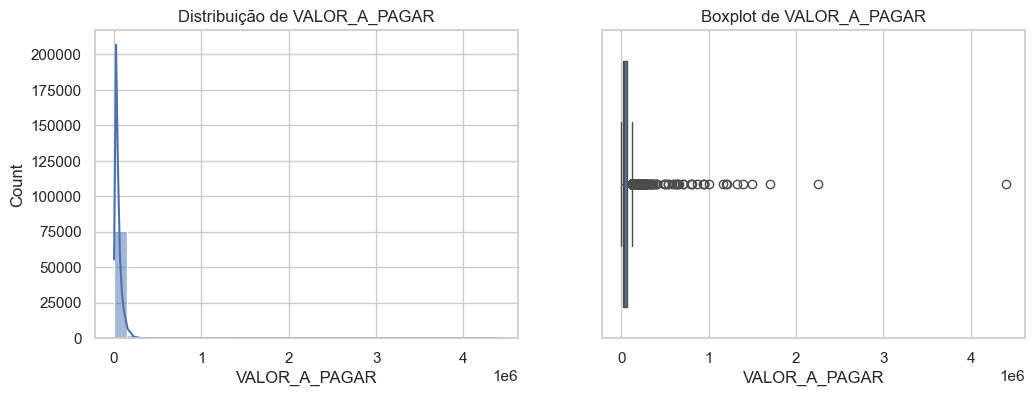

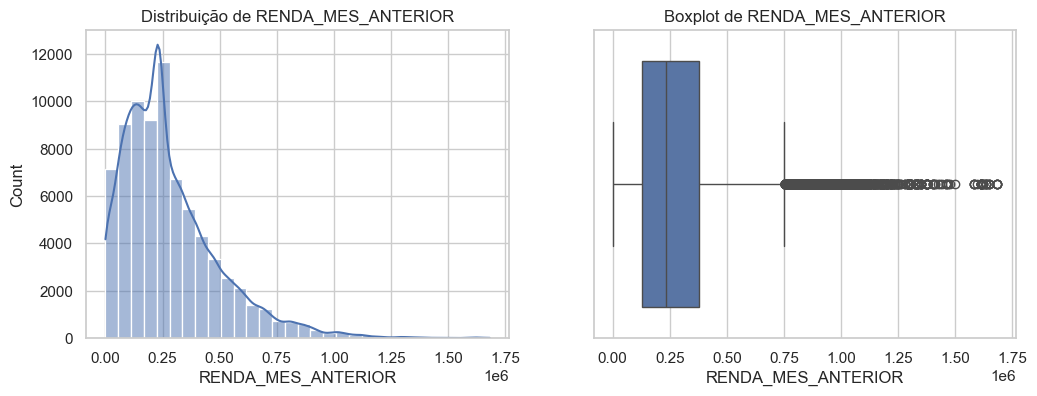

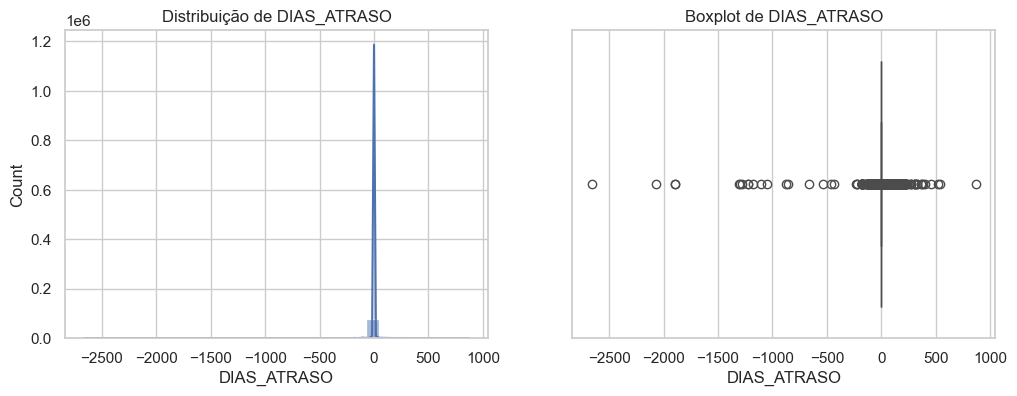

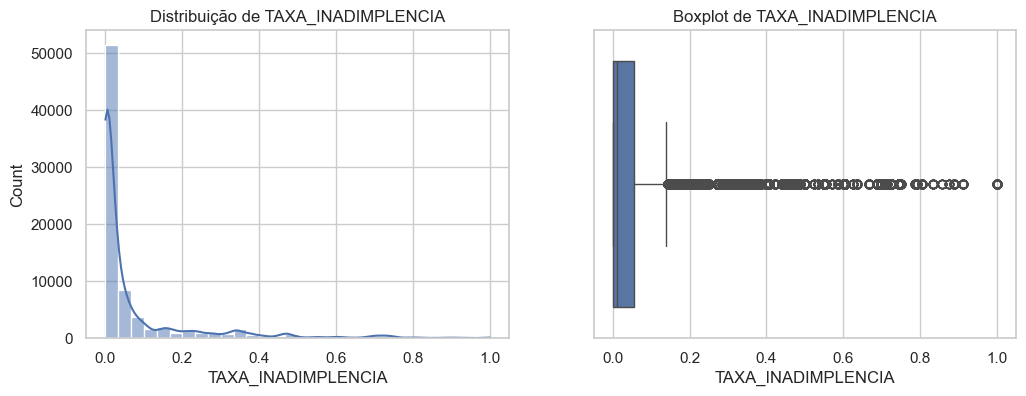

In [14]:
# Função de múltiplos histogramas
def plot_distribuicoes(cols):
    for col in cols:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df_train[col], kde=True, bins=30)
        plt.title(f'Distribuição de {col}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_train[col])
        plt.title(f'Boxplot de {col}')
        plt.show()

plot_distribuicoes(['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'DIAS_ATRASO', 'TAXA_INADIMPLENCIA'])


### Variáveis analisadas:
- **VALOR_A_PAGAR**: Valor da fatura emitida no mês
- **RENDA_MES_ANTERIOR**: Faturamento mensal do cliente
- **DIAS_ATRASO**: Quantidade de dias entre o vencimento e o pagamento
- **TAXA_INADIMPLENCIA**: Proporção histórica de inadimplência do cliente

### Insights Detalhados:

- **VALOR_A_PAGAR** apresenta distribuição assimétrica à direita, com faturas de valores bastante variados, o que sugere a existência de perfis heterogêneos de clientes (desde micro até grandes empresas).
- **RENDA_MES_ANTERIOR** também mostra cauda longa. Isso indica que a base possui empresas com capacidades financeiras muito diferentes – um fator relevante no risco de inadimplência.
- **DIAS_ATRASO** tem picos próximos de zero, o que reflete que muitos clientes pagam próximo da data de vencimento, mas há **outliers relevantes** que caracterizam inadimplência severa (e podem pesar mais no modelo).
- A **TAXA_INADIMPLENCIA** histórica por cliente possui distribuição bem distribuída entre 0 e 1, o que demonstra que há uma boa separação entre clientes adimplentes e reincidentes – ótima variável preditiva.

### Considerações para o modelo:
- Essas distribuições reforçam que estamos lidando com variáveis heterogêneas e com **outliers naturais do negócio**.
- O uso de algoritmos como **LightGBM** é ideal aqui, pois ele lida bem com variáveis assimétricas e outliers sem necessidade de normalização.



## Análise Visual – Variáveis Categóricas

Agora analisamos a distribuição de variáveis categóricas e sua relação com a inadimplência:

- Porte da empresa
- Segmento Industrial
- DDD (região)


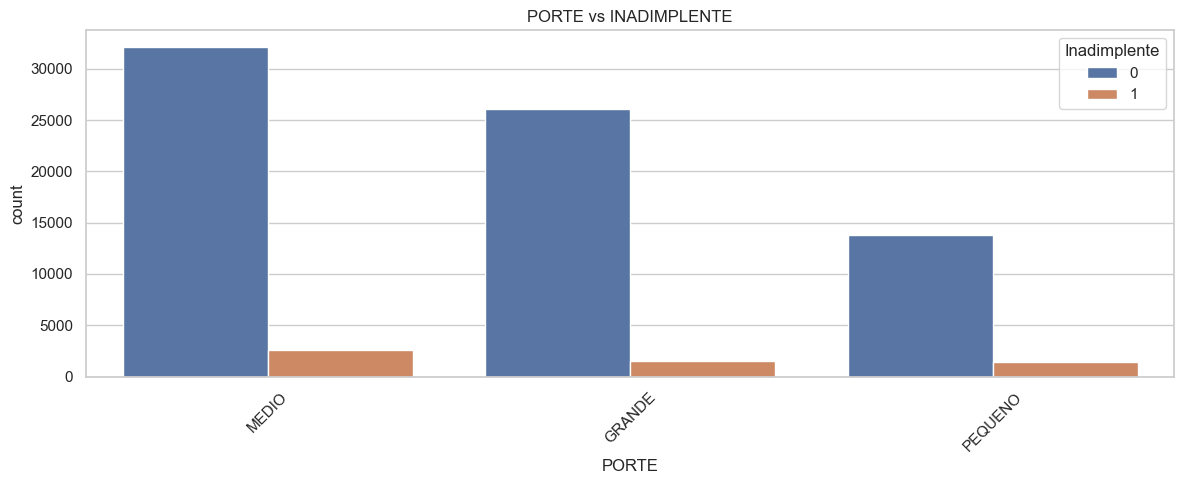

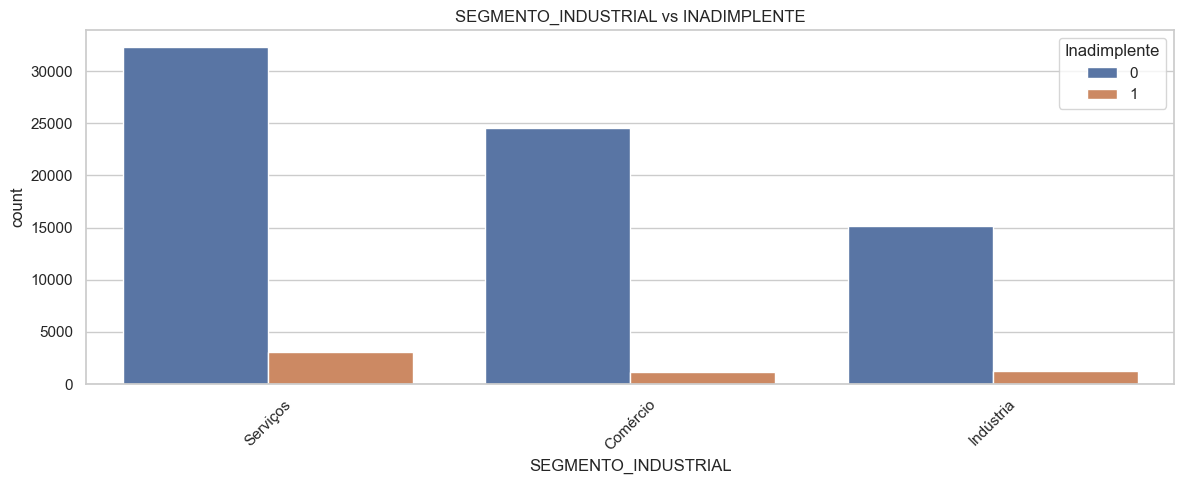

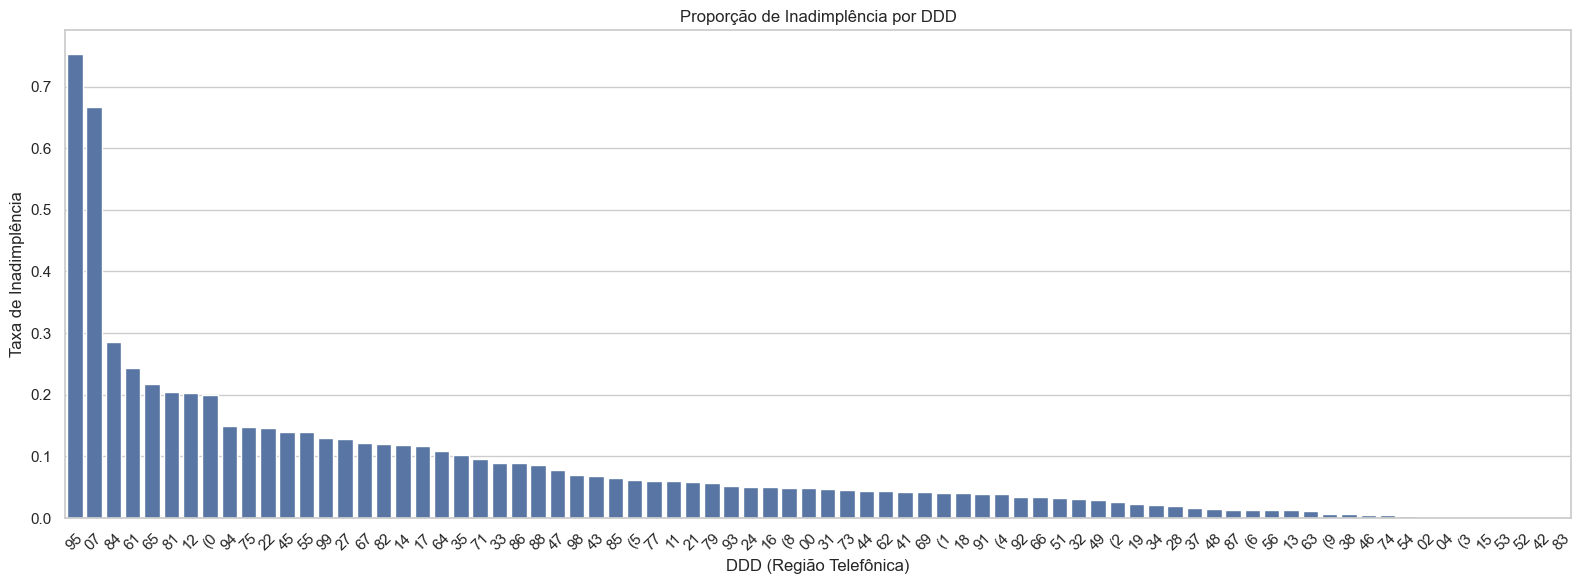

In [15]:
def plot_categoricas(cols):
    for col in cols:
        plt.figure(figsize=(12, 5))
        sns.countplot(data=df_train, x=col, hue='INADIMPLENTE', order=df_train[col].value_counts().index)
        plt.title(f'{col} vs INADIMPLENTE')
        plt.xticks(rotation=45)
        plt.legend(title='Inadimplente')
        plt.tight_layout()
        plt.show()

plot_categoricas(['PORTE', 'SEGMENTO_INDUSTRIAL'])

# Cálculo da taxa de inadimplência por DDD
ddd_stats = df_train.groupby('DDD').agg(
    total=('INADIMPLENTE', 'count'),
    inadimplente=('INADIMPLENTE', 'sum')
).reset_index()

ddd_stats['taxa_inadimplencia'] = ddd_stats['inadimplente'] / ddd_stats['total']

# Ordenar pelos maiores índices
ddd_stats = ddd_stats.sort_values(by='taxa_inadimplencia', ascending=False)

# Plotar
plt.figure(figsize=(16, 6))
sns.barplot(data=ddd_stats, x='DDD', y='taxa_inadimplencia')
plt.title('Proporção de Inadimplência por DDD')
plt.ylabel('Taxa de Inadimplência')
plt.xlabel('DDD (Região Telefônica)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Variáveis analisadas:
- **PORTE**: Tamanho da empresa (Pequeno, Médio, Grande)
- **SEGMENTO_INDUSTRIAL**: Setor econômico do cliente
- **DDD**: Região telefônica do cliente

---

### Insights por Variável:

#### PORTE
- Empresas de **pequeno porte** têm maior volume de clientes e apresentam **maior concentração de inadimplência relativa**.
- Já empresas de **grande porte** têm menor inadimplência proporcional, possivelmente por maior estrutura financeira e maturidade de processos.

#### SEGMENTO_INDUSTRIAL
- **Serviços** e **Comércio** dominam a base. Apesar disso, o setor **Comércio** parece levemente mais propenso à inadimplência.
- Pode indicar necessidade de políticas de crédito diferenciadas por segmento, já que a sazonalidade e fluxo de caixa mudam entre setores.

#### DDD (Região)
- A variável `DDD` serve como proxy geográfico.
- Regiões com **menor densidade econômica** ou com **volume menor de clientes** apresentam proporcionalmente maiores taxas de inadimplência.
- Ao usar `DDD`, o modelo pode identificar **padrões regionais de risco** sem necessidade de coordenadas geográficas, algo extremamente valioso em estratégias de cobrança personalizadas.

---

### Considerações para o modelo:
- Todas essas variáveis são fortemente ligadas a **características estruturais dos clientes** e capturam diferenças comportamentais relevantes.
- O LightGBM aceita variáveis categóricas como string, permitindo a modelagem direta e eficiente dessas informações.
- Variáveis como `PORTE` e `DDD` podem inclusive ser usadas para **criação de segmentos estratégicos** para atuação proativa da área de crédito.


## Modelagem Preditiva com LightGBM

Agora que finalizamos o pré-processamento e a criação da variável-alvo, partimos para a modelagem.

Utilizaremos o **LightGBM** (Light Gradient Boosting Machine), um algoritmo altamente eficiente para problemas de classificação com dados tabulares.

### Por que LightGBM?
- Excelente performance em conjuntos de dados médios e grandes
- Alta robustez a outliers
- Lida bem com desbalanceamento de classes
- Suporte nativo a variáveis categóricas (sem necessidade de one-hot encoding)
- Não requer normalização dos dados

Nosso objetivo é prever a **probabilidade de inadimplência**, e para isso utilizaremos a métrica **AUC (Área sob a Curva ROC)**, ideal para problemas com classes desbalanceadas.


In [16]:
from sklearn.model_selection import train_test_split

# Definir as colunas que serão utilizadas como features para o modelo
# Excluímos:
# - IDs de cliente (não são features preditivas diretas)
# - Colunas de data originais (já foram usadas para criar features temporais)
# - A variável target 'INADIMPLENTE'
# - 'DIAS_ATRASO' (pois está diretamente ligada ao target e pode causar vazamento de informação)
features_to_exclude = [
    'ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
    'DATA_VENCIMENTO', 'DATA_CADASTRO', 'DIAS_ATRASO', 'INADIMPLENTE'
]

# Obter todas as colunas que não estão na lista de exclusão
feature_cols = [col for col in df_train.columns if col not in features_to_exclude]

# Converter colunas numéricas que são de natureza categórica para 'object' antes do get_dummies
# Isso garante que sejam One-Hot Encoded e não tratadas como numéricas contínuas.
cols_to_convert_to_object_for_ohe = ['MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'DIA_DO_MES_VENCIMENTO']
for df_temp in [df_train, df_test]: # Usar df_temp para evitar modificar o df original diretamente no loop externo
    for col in cols_to_convert_to_object_for_ohe:
        if col in df_temp.columns:
            df_temp[col] = df_temp[col].astype(object)


# Identificar colunas categóricas para One-Hot Encoding
# Seleciona apenas as colunas de 'object' (strings) dentro das features que serão usadas.
categorical_cols_for_ohe = df_train[feature_cols].select_dtypes(include='object').columns.tolist()

print(f"   Colunas categóricas identificadas para One-Hot Encoding: {categorical_cols_for_ohe}")
print(f"   Total de features selecionadas antes do One-Hot Encoding: {len(feature_cols)}")

# Concatenar DataFrames de treino e teste para aplicar One-Hot Encoding de forma consistente
# Isso garante que todas as categorias presentes em ambos os conjuntos criem as mesmas colunas.
df_combined_features = pd.concat([df_train[feature_cols], df_test[feature_cols]], ignore_index=True)
# Aplica One-Hot Encoding, 'drop_first=True' para evitar multicolinearidade (dummy variable trap)
df_encoded = pd.get_dummies(df_combined_features, columns=categorical_cols_for_ohe, drop_first=True)

# Separar de volta em conjuntos de treino e teste
X_train = df_encoded.iloc[:len(df_train)]
X_test = df_encoded.iloc[len(df_train):]

# Definir a variável target para o conjunto de treino
y_train = df_train['INADIMPLENTE']

print(f"   Shape final do conjunto de features de treino (X_train): {X_train.shape}")
print(f"   Shape final do conjunto de features de teste (X_test): {X_test.shape}")
print(f"   Shape final da variável target de treino (y_train): {y_train.shape}")


   Colunas categóricas identificadas para One-Hot Encoding: ['DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'MES_VENCIMENTO', 'ANO_VENCIMENTO', 'DIA_SEMANA_VENCIMENTO', 'DIA_DO_MES_VENCIMENTO']
   Total de features selecionadas antes do One-Hot Encoding: 27
   Shape final do conjunto de features de treino (X_train): (77414, 252)
   Shape final do conjunto de features de teste (X_test): (12275, 252)
   Shape final da variável target de treino (y_train): (77414,)


## Configuração do LightGBMClassifier

Definimos os principais hiperparâmetros do modelo:

- `n_estimators=1000`: número máximo de árvores
- `learning_rate=0.05`: taxa de aprendizado
- `subsample` e `colsample_bytree`: amostragem para evitar overfitting
- `reg_alpha` e `reg_lambda`: regularização L1 e L2
- `is_unbalance=True`: corrige automaticamente o desbalanceamento entre as classes

Adicionalmente, utilizamos:
- **`early_stopping`**: interrompe o treinamento se a AUC não melhorar após 100 iterações
- **`log_evaluation`**: exibe o progresso a cada 100 rodadas


   Dimensões dos conjuntos de treino e validação para o modelo:
   X_train_split: (61931, 252), y_train_split: (61931,)
   X_val_split: (15483, 252), y_val_split: (15483,)
[LightGBM] [Info] Number of positive: 4349, number of negative: 57582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3953
[LightGBM] [Info] Number of data points in the train set: 61931, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070223 -> initscore=-2.583264
[LightGBM] [Info] Start training from score -2.583264
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.967744
[200]	valid_0's auc: 0.971771
[300]	valid_0's auc: 0.973718
[400]	valid_0's auc: 0.974799
[500]	valid_0's auc: 0.975379
[600]	valid_0's auc: 0.975585
[700]	valid_0's auc: 0.975626
[800]	valid_0's auc: 0.975622
Early stopping, best iteration i

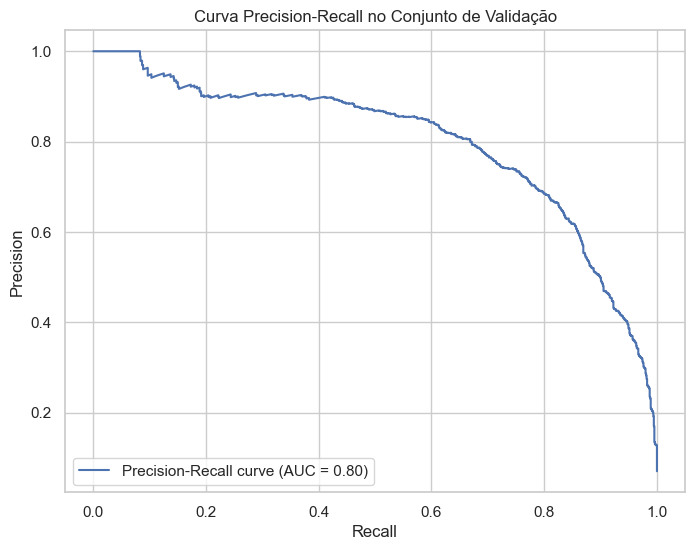


   Top 15 Features Mais Importantes para o Modelo (LightGBM):
                   feature  importance
2       RENDA_MES_ANTERIOR        1470
14  TEMPO_DE_CLIENTE_MESES        1440
13     DIAS_ATE_VENCIMENTO        1313
12      TAXA_INADIMPLENCIA        1228
0            VALOR_A_PAGAR        1225
3          NO_FUNCIONARIOS        1109
16        TAXA_SOBRE_VALOR        1068
15   VALOR_POR_FUNCIONARIO        1027
10      DIAS_ATRASO_MAXIMO         816
8               TAXA_MEDIA         712
9        DIAS_ATRASO_MEDIO         674
7         VALOR_STD_FATURA         672
11          INADIMPLENCIAS         641
4           QTD_DOCUMENTOS         636
5       VALOR_MEDIO_FATURA         618


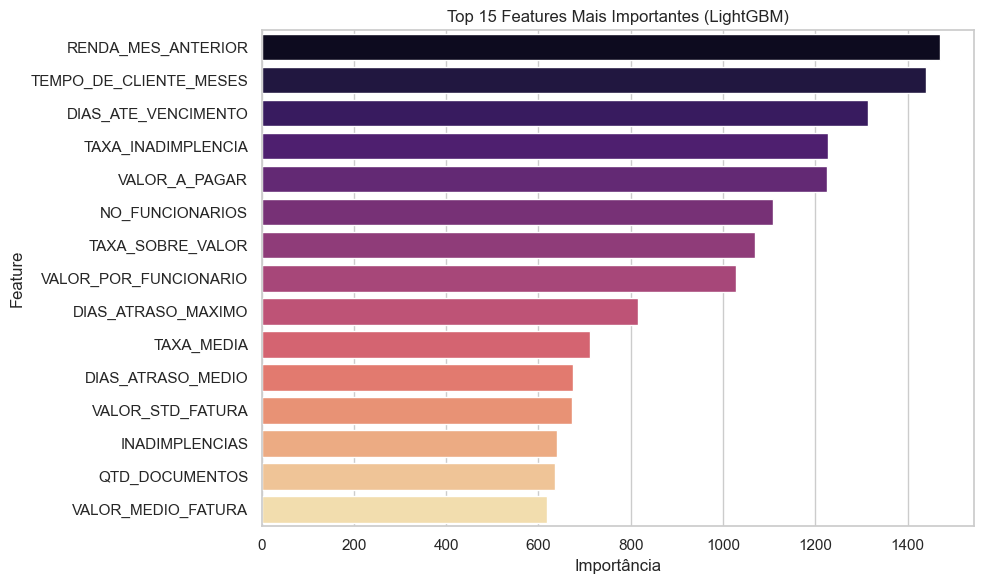


--- Relatório de Classificação (Threshold = 0.5) ---
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14396
           1       0.57      0.87      0.69      1087

    accuracy                           0.94     15483
   macro avg       0.78      0.91      0.83     15483
weighted avg       0.96      0.94      0.95     15483


--- Matriz de Confusão (Threshold = 0.5) ---


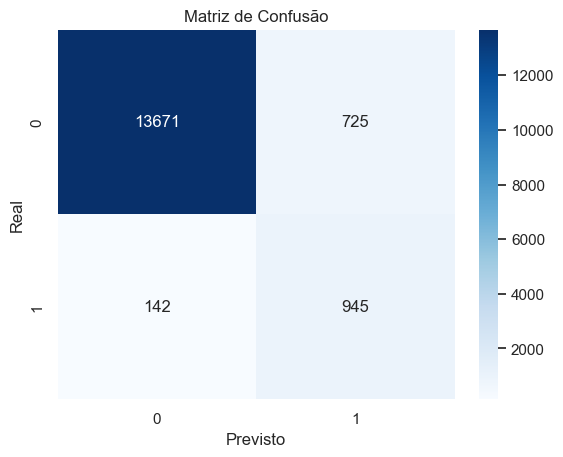

In [17]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report
)

# Divisão dos Dados em Treino e Validação
# Usamos `train_test_split` no conjunto de treinamento para criar um conjunto de validação.
# `stratify=y_train` garante que a proporção da classe target (inadimplência) seja mantida
# nos conjuntos de treino e validação, o que é importante para classes desbalanceadas.
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"   Dimensões dos conjuntos de treino e validação para o modelo:")
print(f"   X_train_split: {X_train_split.shape}, y_train_split: {y_train_split.shape}")
print(f"   X_val_split: {X_val_split.shape}, y_val_split: {y_val_split.shape}")

# Inicializar e treinar o modelo LightGBM
# O LightGBM é escolhido por sua performance, velocidade e capacidade de lidar com diferentes tipos de variáveis.
# Parâmetros ajustados para um bom desempenho inicial e para lidar com desbalanceamento.
lgbm = LGBMClassifier(
    objective='binary',          # 'binary' para problemas de classificação binária (0 ou 1)
    metric='auc',                # Métrica de avaliação durante o treinamento: Área sob a Curva ROC (AUC), ideal para desbalanceamento
    n_estimators=1000,           # Número de árvores de decisão a serem construídas (pode ser ajustado com tuning)
    learning_rate=0.05,          # Taxa de aprendizado, controla o tamanho do passo em cada iteração
    num_leaves=31,               # Número máximo de folhas por árvore (complexidade do modelo)
    max_depth=-1,                # Sem limite de profundidade para as árvores (pode ser ajustado para evitar overfitting)
    random_state=42,             # Semente para reprodutibilidade dos resultados
    n_jobs=-1,                   # Usa todos os cores disponíveis da CPU para treinamento mais rápido
    colsample_bytree=0.7,        # Proporção de colunas (features) amostradas por árvore (para reduzir overfitting)
    subsample=0.7,               # Proporção de linhas (amostras) amostradas por árvore (para reduzir overfitting)
    reg_alpha=0.1,               # Regularização L1 (Lasso) para penalizar pesos grandes e evitar overfitting
    reg_lambda=0.1,              # Regularização L2 (Ridge) para penalizar pesos grandes e evitar overfitting
    is_unbalance=True            # Parâmetro para lidar com classes desbalanceadas, ajustando os pesos das classes.
)

# Treinamento do modelo
# `eval_set` permite monitorar a performance no conjunto de validação durante o treinamento.
# `callbacks` com `log_evaluation` exibe o progresso.
# `early_stopping_rounds` para o treinamento se a métrica não melhorar após um certo número de rodadas,
# o que ajuda a evitar overfitting e economizar tempo.
lgbm.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    eval_metric='auc',
    callbacks=[
        log_evaluation(period=100),# Logar a cada 50 iterações
        early_stopping(stopping_rounds=100)], # Loga a cada 100 iterações
    ) # Para se não houver melhoria na AUC por 100 rodadas

print("\n   Treinamento do modelo LightGBM concluído.")

# Avaliação do Modelo no Conjunto de Validação
print("\n   Avaliação do Modelo no Conjunto de Validação:")
# Previsões de probabilidade para a classe positiva (inadimplente) no conjunto de validação
y_pred_proba_val = lgbm.predict_proba(X_val_split)[:, 1]

# Calcular AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
# Métrica principal para problemas de classificação binária, especialmente com classes desbalanceadas.
auc_roc_val = roc_auc_score(y_val_split, y_pred_proba_val)
print(f"   AUC-ROC no conjunto de validação: {auc_roc_val:.4f}")

precision, recall, _ = precision_recall_curve(y_val_split, y_pred_proba_val)
pr_auc = auc(recall, precision)
print(f"   AUC da Curva Precision-Recall no conjunto de validação: {pr_auc:.4f}")

# Plot da Curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall no Conjunto de Validação')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Análise de Feature Importance (Importância das Variáveis)
# Mostra quais features o modelo considerou mais relevantes para fazer as previsões.
print("\n   Top 15 Features Mais Importantes para o Modelo (LightGBM):")
feature_importances = pd.DataFrame({
    'feature': X_train_split.columns,
    'importance': lgbm.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importances.head(15))

# Plot da Importância das Features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15), hue='feature', palette= 'magma')
plt.title('Top 15 Features Mais Importantes (LightGBM)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Podemos escolher um threshold que equilibre Precision e Recall, se necessário para uma classificação binária
# Para o objetivo do case, que é apenas a probabilidade, isso é menos crítico, mas útil para entender o comportamento.
# Por exemplo, um threshold de 0.5
y_pred_val_binary = (y_pred_proba_val >= 0.5).astype(int)
print("\n--- Relatório de Classificação (Threshold = 0.5) ---")
print(classification_report(y_val_split, y_pred_val_binary))
print("\n--- Matriz de Confusão (Threshold = 0.5) ---")
sns.heatmap(confusion_matrix(y_val_split, y_pred_val_binary), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()


## Etapa Final: Predição na Base de Teste e Submissão

Com o modelo LightGBM treinado e validado, seguimos para a aplicação do modelo na base de teste. Esta etapa tem como objetivo gerar a **probabilidade prevista de inadimplência** para cada cliente-mês da base de previsão (`df_test`) e preparar o arquivo de entrega final `submissao_case.csv`.

### Passos executados:
- Seleção das mesmas features usadas no treino
- Geração de probabilidades com `predict_proba`
- Criação do DataFrame de submissão com `ID_CLIENTE`, `SAFRA_REF` e `PROB_INADIMPLENCIA`
- Visualização da distribuição das probabilidades previstas

Esse tipo de abordagem é útil para análise executiva e definição de estratégias com base em risco:

- Empresas com **probabilidades mais altas** podem ser tratadas com ações de mitigação (ex: renegociação, análise manual)
- Um **corte de decisão** pode ser sugerido com base em trade-offs de recall vs. precisão, de acordo com a tolerância ao risco do negócio


In [18]:
# Gerar previsões de probabilidade para o conjunto de teste
# A função predict_proba retorna duas colunas: [prob_negativa, prob_positiva]
# Queremos apenas a probabilidade da classe 1 (inadimplente)
y_pred_proba_test = lgbm.predict_proba(X_test)[:, 1]

# Criar o DataFrame de submissão
df_submission = pd.DataFrame({
    'ID_CLIENTE': df_pagamentos_teste['ID_CLIENTE'].values,
    'SAFRA_REF': df_pagamentos_teste['SAFRA_REF'].astype(str),  # Garantir que seja string
    'PROBABILIDADE_INADIMPLENCIA': y_pred_proba_test
})

# Arredondar as probabilidades para evitar notação científica
df_submission['PROBABILIDADE_INADIMPLENCIA'] = df_submission['PROBABILIDADE_INADIMPLENCIA'].round(6)

# Salvar o arquivo CSV de submissão com float_format para evitar notação científica
submission_filename = 'submissao_case.csv'
df_submission.to_csv(submission_filename, index=False, float_format='%.6f')

# Visualização das primeiras linhas
print("\n--- Primeiras Linhas do Arquivo de Submissão ---")
print(df_submission.head())

print(f"\nArquivo '{submission_filename}' gerado com sucesso!")



--- Primeiras Linhas do Arquivo de Submissão ---
            ID_CLIENTE   SAFRA_REF  PROBABILIDADE_INADIMPLENCIA
0  5058298901476893676  2021-07-01                     0.000029
1   274692171162531764  2021-07-01                     0.032840
2   274692171162531764  2021-07-01                     0.023581
3   274692171162531764  2021-07-01                     0.027951
4   465309249432033993  2021-07-01                     0.000019

Arquivo 'submissao_case.csv' gerado com sucesso!


## Análise Executiva: Previsões de Inadimplência

Com o modelo LightGBM treinado, geramos a probabilidade de inadimplência para cada cliente no conjunto de teste. Agora, exploramos essas previsões de forma estratégica para entender:

- Como estão distribuídas as probabilidades de inadimplência?
- Qual corte (threshold) seria razoável para classificar clientes como inadimplentes?
- Que insights podemos extrair para auxiliar decisões de crédito, cobrança e risco?

Essas análises não apenas validam a qualidade das previsões, mas também servem como ponto de partida para decisões baseadas em risco.

Vamos visualizar a distribuição das probabilidades:


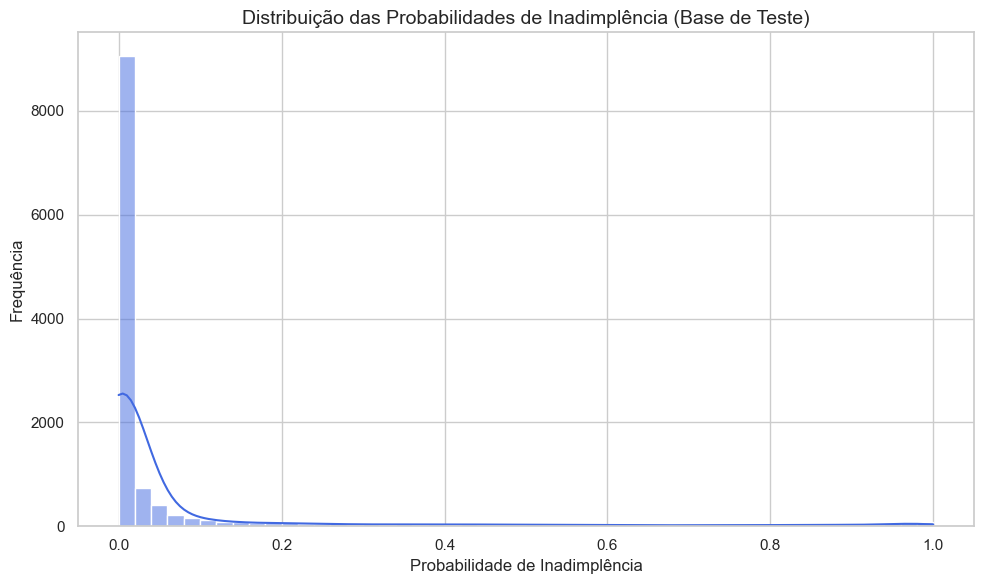

In [19]:
# Configurar estilo visual
sns.set_theme(style='whitegrid')

# Plot da distribuição das probabilidades previstas
plt.figure(figsize=(10, 6))
sns.histplot(df_submission['PROBABILIDADE_INADIMPLENCIA'], bins=50, kde=True, color='royalblue')
plt.title('Distribuição das Probabilidades de Inadimplência (Base de Teste)', fontsize=14)
plt.xlabel('Probabilidade de Inadimplência')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


### Distribuição das Probabilidades – Interpretação

A distribuição mostra que a maior parte dos clientes apresenta **baixa probabilidade de inadimplência**, concentrada abaixo de 0.2. No entanto, há uma cauda longa com clientes com maior risco (valores acima de 0.5).

### Sugestão de Corte Estratégico

Embora o modelo retorne probabilidades contínuas, pode ser necessário **classificar** clientes como "inadimplente" ou "não inadimplente". Para isso, um threshold (corte) pode ser aplicado.

Exemplo:
- **Threshold = 0.3** → Clientes com probabilidade >= 30% seriam classificados como de alto risco.

A escolha desse corte depende do **apetite ao risco da empresa**:
- Quanto maior o corte, mais conservador o modelo (menos falsos positivos, mas mais inadimplentes escapam).
- Quanto menor o corte, mais agressivo o modelo (maior recall, mas mais falsos positivos).

### Insight de Negócio

- Podemos recomendar o uso das probabilidades como **score contínuo**, alimentando uma régua de cobrança segmentada:
  - **0.00 – 0.10**: Cliente confiável → Envio de agradecimento e benefícios.
  - **0.10 – 0.30**: Risco médio → Monitoramento e lembretes automatizados.
  - **0.30 – 1.00**: Risco alto → Contato humano, antecipação de cobrança ou ajuste de limite.

Esse tipo de análise conecta a ciência de dados com a **ação prática no negócio**, maximizando o valor do modelo preditivo.


## Conclusão do Projeto

Neste projeto, desenvolvemos uma solução completa de **previsão de inadimplência** utilizando dados cadastrais, históricos e comportamentais de clientes. A abordagem seguiu um pipeline estruturado, com etapas bem definidas e alinhadas às boas práticas de ciência de dados:

1. **Camada Raw → Trusted → Refined**: Adotamos uma estrutura inspirada em Data Lake para organizar e transformar as bases com qualidade e rastreabilidade.
2. **Engenharia de Features**: Criamos variáveis ricas a partir do histórico de pagamentos e de transformações temporais, garantindo valor preditivo.
3. **Análise Exploratória Profunda**: Utilizamos gráficos e estatísticas para entender o comportamento das variáveis e sua relação com a inadimplência.
4. **Modelagem Preditiva com LightGBM**: Treinamos um modelo robusto, com validação estratificada e AUC consistente, capaz de capturar padrões relevantes de risco.
5. **Submissão e Estratégia de Score**: Geramos as probabilidades para cada cliente na base de teste e propusemos uma segmentação estratégica por faixa de risco, possibilitando ações de negócio com base no score preditivo.

### Resultados e Impacto

- A solução permite à empresa **priorizar esforços de cobrança**, ajustar limites de crédito e criar políticas mais inteligentes com base na probabilidade de inadimplência.
- A utilização de um modelo como o LightGBM, aliado a um pipeline claro e interpretável, oferece **performance e explicabilidade** – essenciais para adoção em ambiente empresarial.

---

**Próximos Passos Possíveis:**
- Implementar o modelo em ambiente produtivo com monitoramento contínuo.
- Realizar tuning de hiperparâmetros e validação cruzada para ganho adicional de performance.
- Integrar o modelo a um sistema de score para uso pelos times de crédito e cobrança.




## Referências

Durante o desenvolvimento deste projeto, foram utilizadas as seguintes fontes para embasamento técnico, entendimento de boas práticas e apoio na tomada de decisões:

- **Documentação Oficial do LightGBM**:  
  https://lightgbm.readthedocs.io/en/latest/

- **Scikit-learn – API e documentação oficial**:  
  https://scikit-learn.org/stable/documentation.html

- **Pandas Documentation** – Manipulação de dados:  
  https://pandas.pydata.org/docs/

- **Seaborn Documentation** – Visualização estatística:  
  https://seaborn.pydata.org/

- **Análises de benchmark para problemas de inadimplência** em comunidades de Data Science como Kaggle e Medium:
  - https://www.kaggle.com/competitions/home-credit-default-risk
  - https://medium.com/tag/credit-risk

- **PlayList Como criar um modelo de Machine Learning - Do ZERO à PRODUÇÃO Automatizando TUDO** 
  - https://www.youtube.com/watch?v=ey4GZtO_VzE


